In [5]:
from util import *
from seq2seq import *
import tltk, jiwer

# additional dict data

In [4]:

df = pd.read_csv('data/g2p_dict.csv')
df.g.to_csv('data/dic_x.txt', index=False, header=None)
df.rtgs.to_csv('data/dic_y.txt', index=False, header=None)

# load data

In [6]:
# load data
train_x = open('data/train_x.txt').read().splitlines()
train_y = open('data/train_y.txt').read().splitlines()
test_x = open('data/test_x.txt').read().splitlines()
test_y = open('data/test_y.txt').read().splitlines()

dic_x = open('data/dic_x.txt').read().splitlines()
dic_y = open('data/dic_y.txt').read().splitlines()

In [7]:
# Instantiation
data = Data()
data.set_train(train_x, train_y)
data.set_test(test_x, test_y)

data.set_train(dic_x, dic_y)

In [8]:
# build model
seq2seq1 = Seq2Seq(data, attention=False)
seq2seq1.build(show_summary=False, opt='rmsprop', loss='categorical_crossentropy')

seq2seq2 = Seq2Seq(data, attention=True)
seq2seq2.build(show_summary=False, opt='rmsprop', loss='categorical_crossentropy')

Epoch 1/5
301/301 [==============================] - 218s 725ms/step - loss: 0.0152 - accuracy: 0.9660
Epoch 2/5
301/301 [==============================] - 219s 728ms/step - loss: 0.0136 - accuracy: 0.9697
Epoch 3/5
301/301 [==============================] - 223s 742ms/step - loss: 0.0123 - accuracy: 0.9726
Epoch 4/5
301/301 [==============================] - 231s 768ms/step - loss: 0.0110 - accuracy: 0.9753
Epoch 5/5
301/301 [==============================] - 230s 763ms/step - loss: 0.0102 - accuracy: 0.9771
Epoch 1/5
301/301 [==============================] - 242s 803ms/step - loss: 0.0030 - accuracy: 0.9938
Epoch 2/5
301/301 [==============================] - 238s 790ms/step - loss: 0.0027 - accuracy: 0.9942
Epoch 3/5
301/301 [==============================] - 242s 802ms/step - loss: 0.0023 - accuracy: 0.9949
Epoch 4/5
301/301 [==============================] - 242s 805ms/step - loss: 0.0021 - accuracy: 0.9955
Epoch 5/5
301/301 [==============================] - 236s 786ms/step - lo

<AxesSubplot:xlabel='Epoch'>

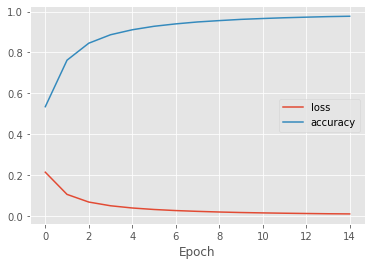

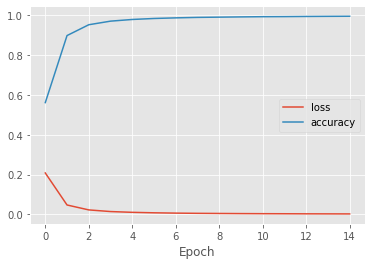

In [13]:
# train
seq2seq1.train(batch_size=100, epoch=5, dev_split=0)
seq2seq2.train(batch_size=100, epoch=5, dev_split=0)

In [17]:
"""
pred1 = seq2seq1.predict(join_by='')
pred2 = seq2seq2.predict(join_by='')
df = pd.DataFrame({'thai':test_x,'pred1':pred1,'pred2':pred2, 'answer':test_y})
pred_tltk = [tltk.nlp.th2roman(x).replace('<s/>','').replace(' ','') for x in list(df.answer)]
df['tltk'] = pred_tltk
"""
df.to_csv('pred_withdic.csv', index=False)

In [16]:
def evaluate(df):
    cols = df.columns
    pred_list = list(df.pred1)
    gold_list = list(df.answer)
    tempdf = pd.DataFrame(index=['WER','CER macro', 'CER micro'])

    for col in cols:
        if col in ['answer', 'thai']:
            continue
        pred_list = list(df[col])
        WER = jiwer.wer(pred_list, gold_list)
        CERmacro = np.mean([jiwer.cer(p,g) for p,g in zip(pred_list, gold_list)])
        CERmicro = sum([jiwer.cer(p,g)*len(g) for p,g in zip(pred_list, gold_list)])/sum([len(g) for g in gold_list])
        tempdf[col] = [WER, CERmacro, CERmicro]
    return tempdf

evaluate(df)

,pred1,pred2,tltk
WER,0.172840,0.108642,0.101235
CER macro,0.043355,0.026617,0.013554
CER micro,0.044962,0.028573,0.013101


In [18]:
len(pred_tltk)

810